In [41]:
import uproot as up
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-v0_8-paper')
plt.rcParams["patch.force_edgecolor"] = True


In [42]:
file_BKG = up.open("../SelectingFeatures/ibd_userfile_7days.root")
dataset = file_BKG ['TRec'].arrays(library = 'np')
en_fact = 0.92
dataset["m_QEn"] = dataset["m_QEn"]*en_fact 

In [43]:
dataset

{'recx': array([ -6546.7075  ,  -5635.7627  ,  13160.146   ,  13114.25    ,
          9512.74    ,   9493.904   ,   1132.0688  ,   1073.1328  ,
        -16363.842   , -16342.987   ,  -3902.0537  ,  -3256.121   ,
         -7268.8853  ,  -7329.297   ,  -2990.6162  ,  -3068.1492  ,
          2861.0417  ,   3193.5686  ,  -6821.294   ,  -6706.689   ,
         -6741.0654  ,  -6734.507   , -10108.988   , -10002.064   ,
          7743.591   ,   7909.612   ,  -3126.876   ,  -3317.5632  ,
         -2819.2124  ,  -2487.6445  ,  -8325.332   ,  -8484.592   ,
           515.6699  ,    558.26807 ,  -6822.737   ,  -6729.9434  ,
         -6225.802   ,  -5766.156   ,  12394.71    ,  12298.789   ,
        -10164.884   , -10189.347   ,  12215.076   ,  11850.723   ,
          -437.16708 ,    246.85396 ,   6930.319   ,   7047.679   ,
        -12826.673   , -12717.704   ,   -105.96205 ,   -304.99368 ,
          3671.4673  ,   3188.2144  ,  -8884.122   ,  -8810.871   ,
        -14609.547   , -14750.935   ,   

In [44]:
xs_reco = file_BKG['TRec']['recx'].array(library = 'np')
ys_reco = file_BKG['TRec']['recy'].array(library = 'np')
zs_reco = file_BKG['TRec']['recz'].array(library = 'np')
es_reco_BKG = file_BKG['TRec']['m_QEn'].array(library = 'np')

rs_reco = np.sqrt(xs_reco**2 + ys_reco**2 + zs_reco**2)

Text(0, 0.5, 'Number of events')

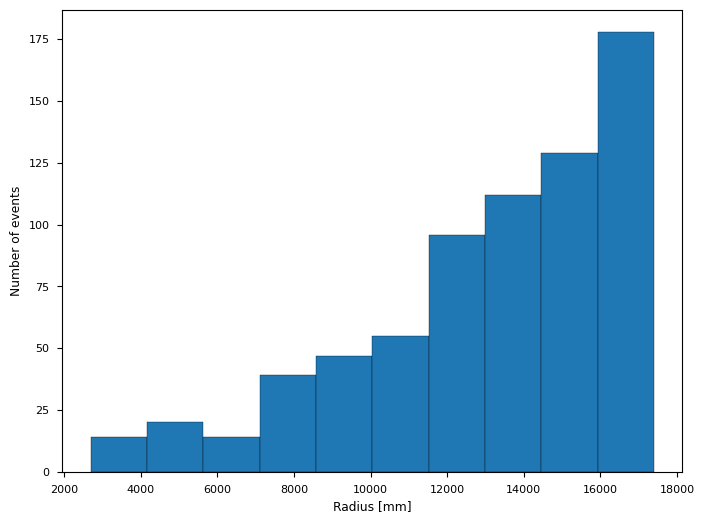

In [45]:
fig, ax = plt.subplots(figsize = (8,6), )
ax.hist(rs_reco)

ax.set_xlabel('Radius [mm]')
ax.set_ylabel('Number of events')

# Cuts

In [46]:
delta_time = 1e6   
delta_radius = 1500 #1.5 m
min_energy_prompt = 0.7 #MeV
max_energy_prompt = 12

min_energy_delay = 1.9 #MeV
max_energy_delay = 2.5

#Here I made some changes
min_energy_delay_carb = 4.4 #MeV
max_energy_delay_carb = 5.5

In [47]:
from numba import njit, prange #prange serve per fare un ciclo for ma eseguito come in c++, molto più veloce


@njit(parallel = True) #il parallel serve per far lavorararre tutti i core in parallelo
def selection(x,y,z,E,t,delta_time = 5 * 220e3, delta_radius = 1500, min_energy_prompt = 0.7,max_energy_prompt = 12, min_energy_delay = 1.9, max_energy_delay = 2.5, min_energy_delay_carb = 4.4, max_energy_delay_carb = 5.5):
    prompt_columns = np.zeros(x.shape)
    delay_columns = np.zeros(x.shape)
    delay_columns_carb = np.zeros(x.shape)

    for i_pro in prange(x.shape[0]-1):
        i_del = i_pro + 1


        if t[i_del] - t[i_pro] < delta_time: 
            if np.sqrt((x[i_del] - x[i_pro])**2 + (y[i_del] - y[i_pro])**2 + (z[i_del] - z[i_pro])**2) < delta_radius: #radius cut
                if E[i_pro]>= min_energy_prompt and E[i_pro]<= max_energy_prompt:
                    if E[i_del]>= min_energy_delay and E[i_del]<= max_energy_delay:
                        prompt_columns[i_pro] = 1
                        delay_columns[i_del] = 1
                    if E[i_del]>= min_energy_delay_carb and E[i_del]<= max_energy_delay_carb:
                        prompt_columns[i_pro] = 1
                        delay_columns_carb[i_del] = 1

    return prompt_columns,delay_columns,delay_columns_carb
    

    


In [48]:
print(dataset['recx'].shape)

cut = 10
prompt_columns, delay_columns, delay_columns_carb = selection(dataset['recx'][:cut],
                                                              dataset['recy'][:cut],
                                                              dataset['recz'][:cut],
                                                              dataset["m_QEn"][:cut],
                                                              dataset["m_triggerT"][:cut])

(704,)


In [49]:
prompt_columns.sum()


5.0

IndexError: boolean index did not match indexed array along dimension 0; dimension is 704 but corresponding boolean dimension is 10

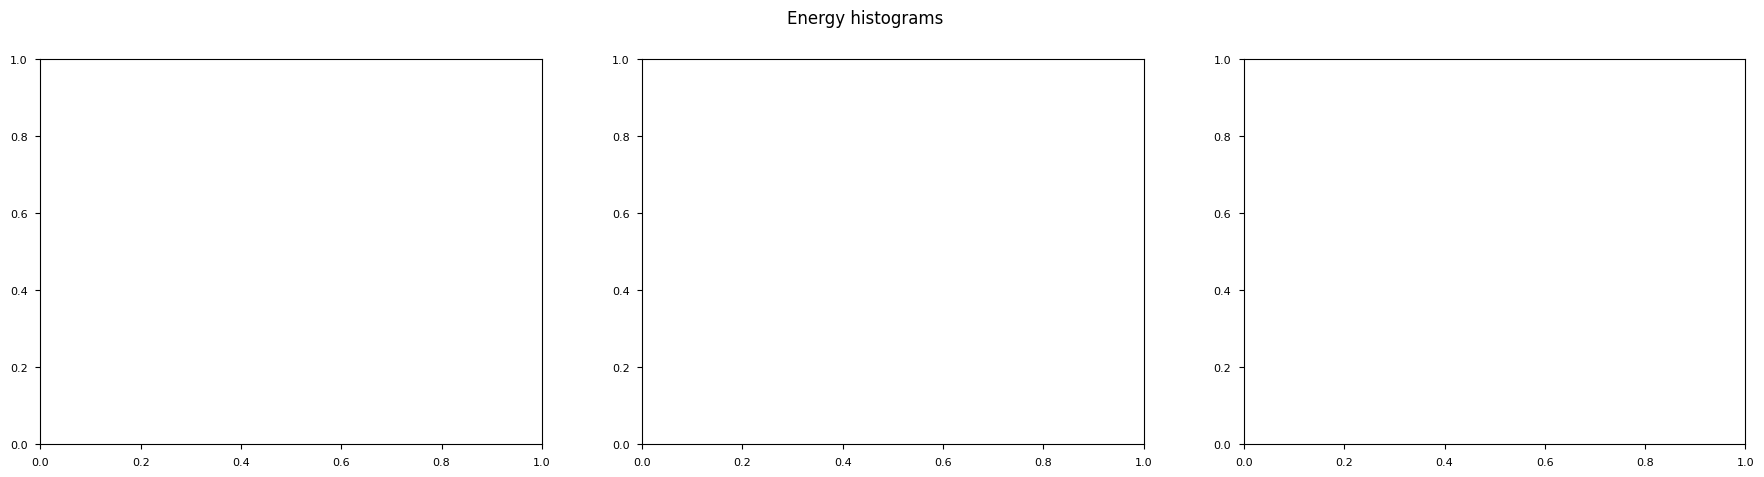

In [50]:
fig_dp, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22,5))
fig_dp.suptitle("Energy histograms")

ax1.hist((dataset["m_QEn"])[prompt_columns.astype(bool)], np.linspace(0.8,12,100))
ax1.set_title("Prompt Events")
ax2.hist((dataset["m_QEn"])[delay_columns.astype(bool)], np.linspace(1.9,2.5,50), color = 'green')
ax2.set_title("Delayed Events")
ax3.hist((dataset["m_QEn"])[delay_columns_carb.astype(bool)], np.linspace(4.4,5.5,40), color = 'red')
ax3.set_title("Delayed Events Carbon")